## PSF - Whistle Autotune App

### Human Single Tone Whistle Caracterization

/home/lorsi/.local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


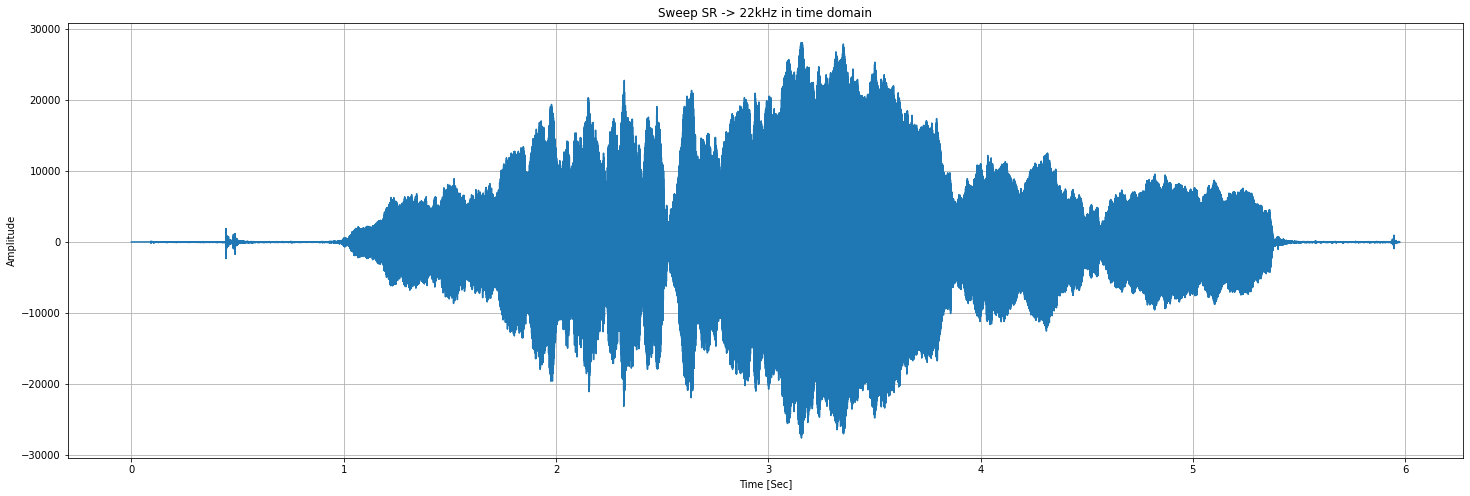

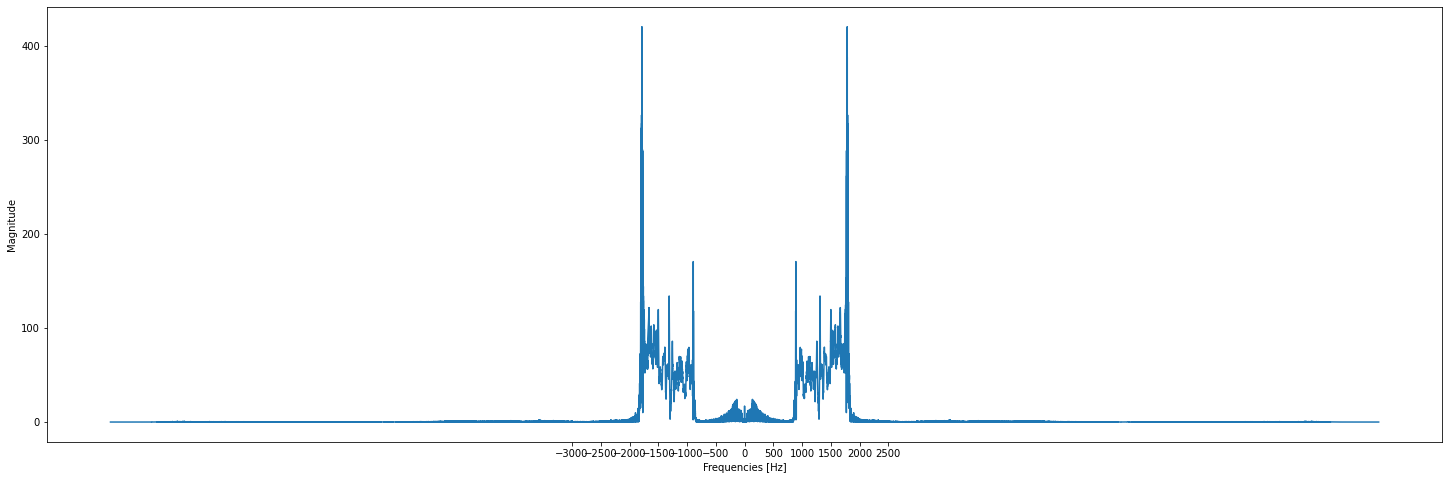

/home/lorsi/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


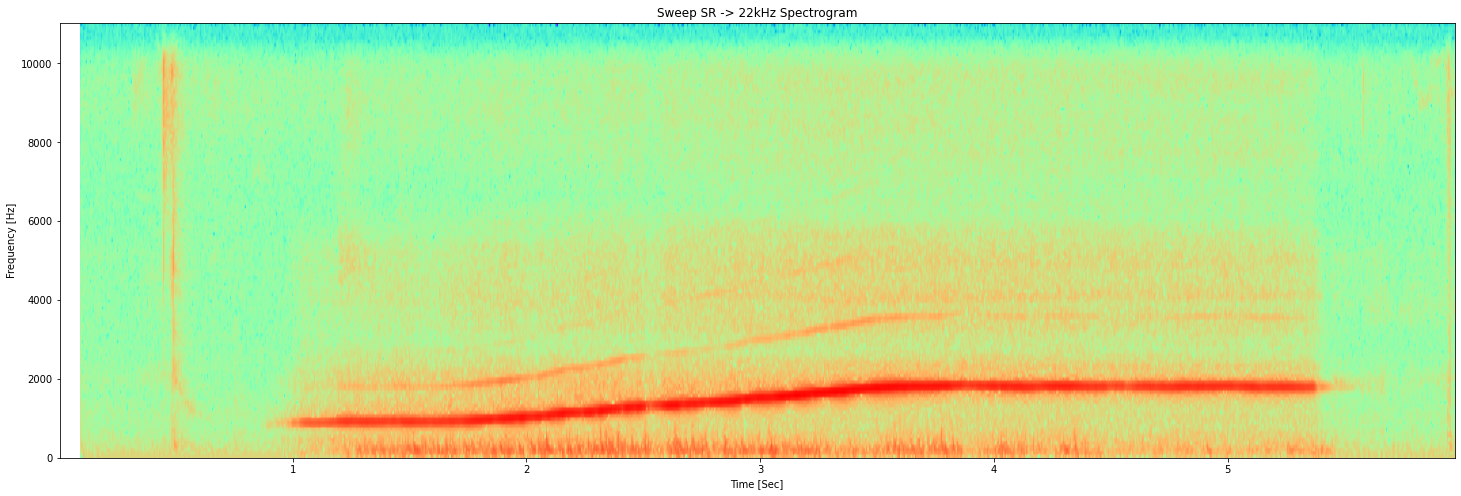

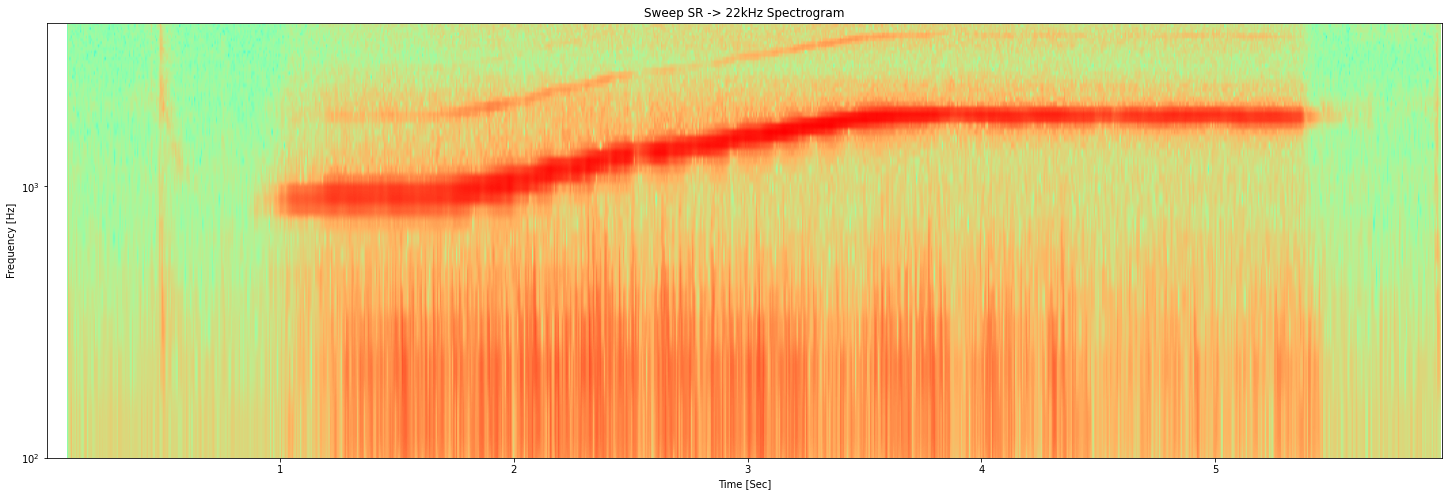

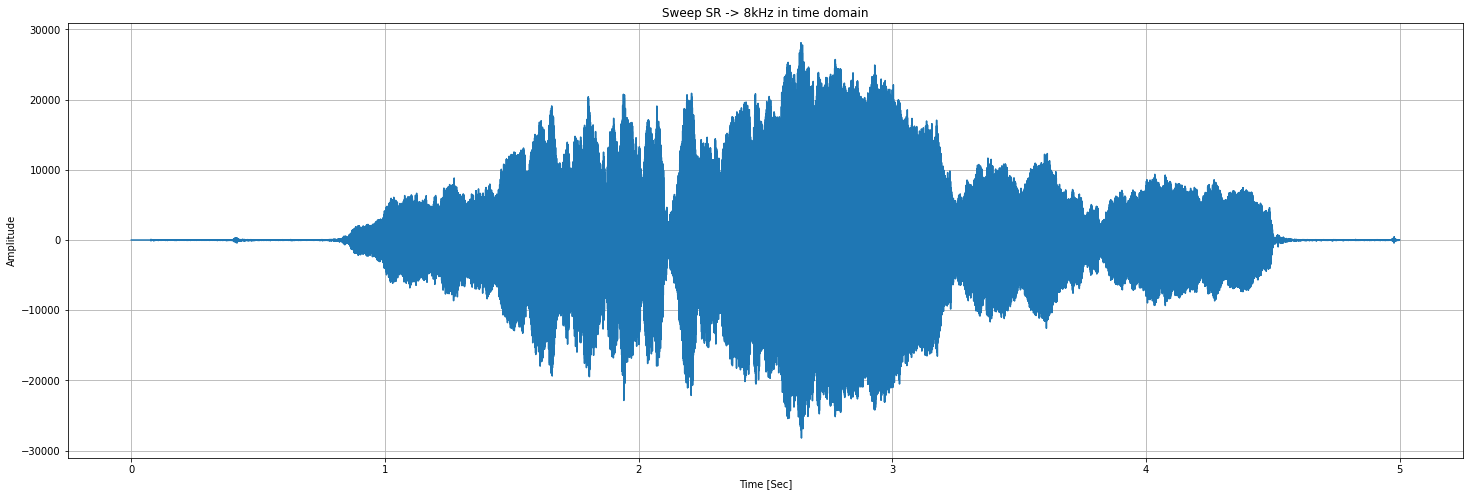

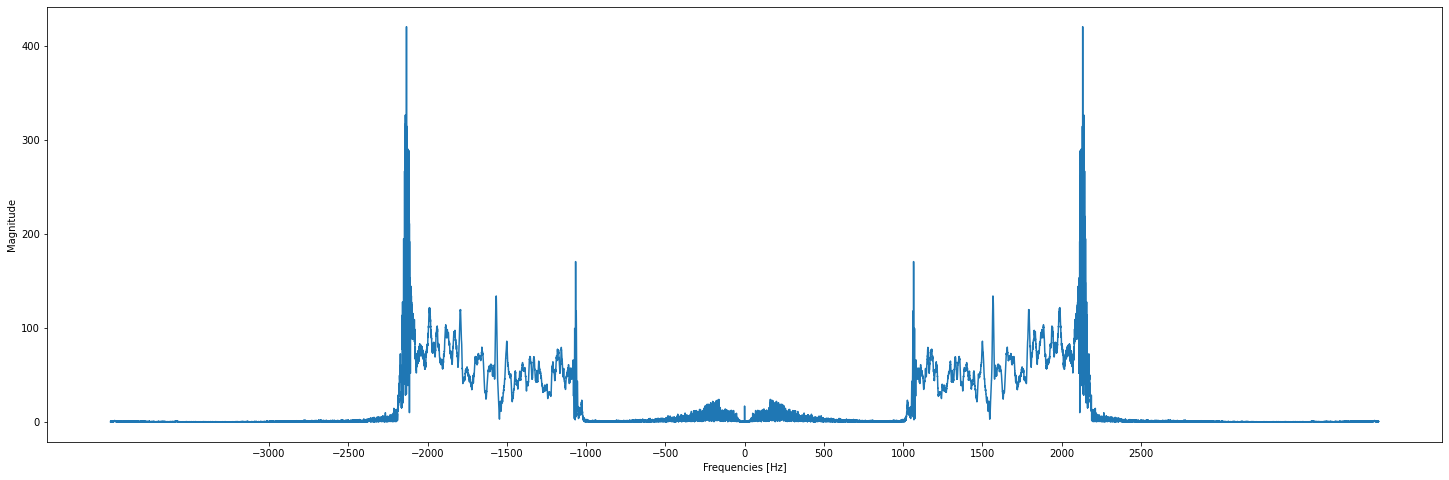

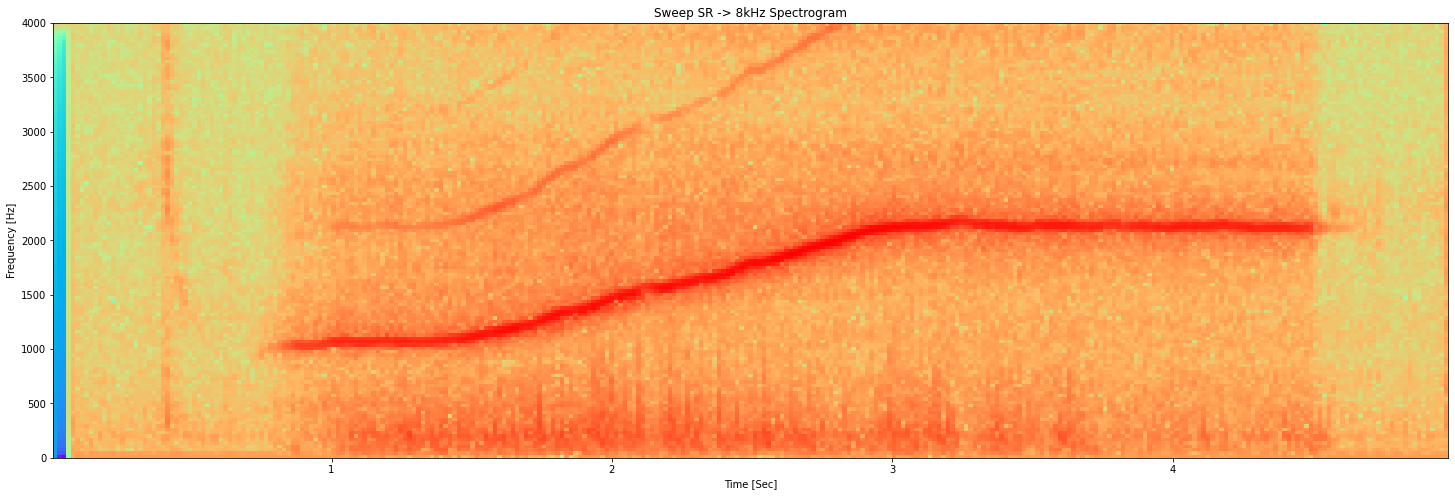

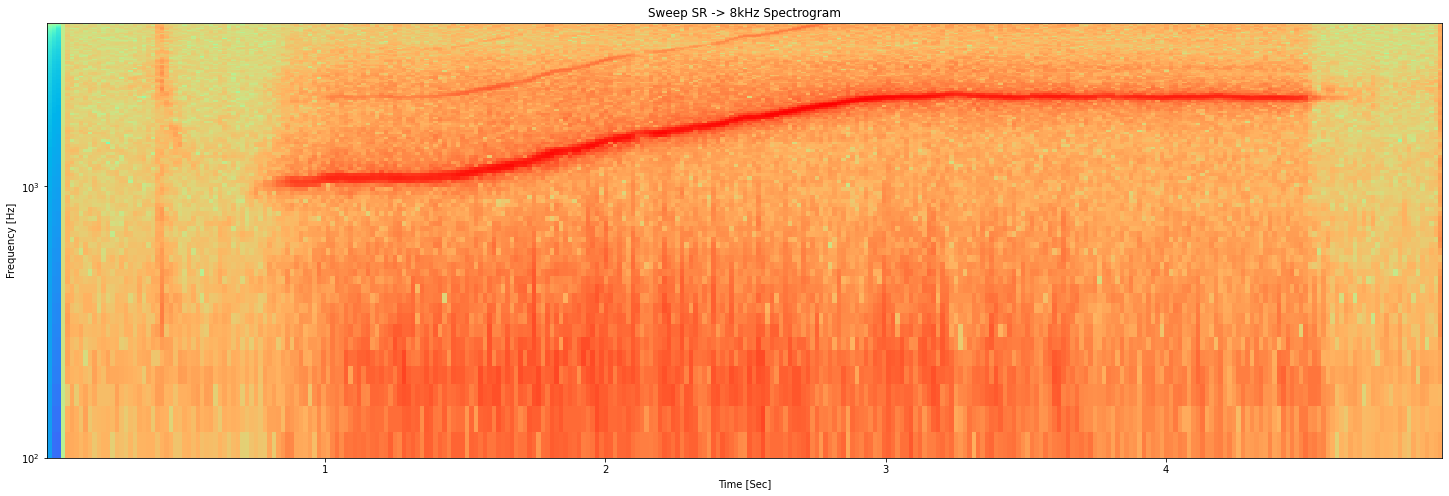

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import librosa


def load_ogg_file_as_npy_int16(fpath: str):
    data, sr = librosa.load(fpath)
    return ((2**16) * data).astype(np.int16), sr


def psf_gen_plots(signal, fs, signame='Signal'):
    time = np.arange(len(signal)) / fs 
    fft = np.abs(np.fft.fftshift(np.fft.fft(signal)/len(signal)))
    fft_fs = np.fft.fftshift(np.fft.fftfreq(len(signal), 1/fs))

    plt.figure(figsize=(25,8))
    plt.plot(time, signal)
    plt.grid()
    plt.ylabel('Amplitude')
    plt.xlabel('Time [Sec]')
    plt.title(f'{signame} in time domain')
    plt.show()

    plt.figure(figsize=(25,8))
    plt.xlabel('Frequencies [Hz]')
    plt.xticks(np.arange(-3000, 3000, 500))
    plt.ylabel('Magnitude')
    plt.plot(fft_fs, fft)
    plt.show()

    plt.figure(figsize=(25,8))
    plt.title(f'{signame} Spectrogram')
    plt.specgram(signal, Fs=fs, cmap="rainbow")
    plt.xlabel('Time [Sec]')
    plt.ylabel('Frequency [Hz]')
    plt.show()


    plt.figure(figsize=(25,8))
    plt.title(f'{signame} Spectrogram')
    plt.specgram(signal, Fs=fs, cmap="rainbow")
    plt.xlabel('Time [Sec]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim((100, 4000))
    plt.yscale('symlog')
    plt.show()


WHILSTE_SWEEP_FILE = './files/whistle_sweep.ogg'
CIAA_SR = 8000

w_sweep, sr = load_ogg_file_as_npy_int16(WHILSTE_SWEEP_FILE);
psf_gen_plots(w_sweep, sr, signame='Sweep SR -> 22kHz');

## Downsampled -- Similar to what the MCU will record
from scipy import signal

down_sweep = signal.resample(w_sweep, len(w_sweep) // sr * CIAA_SR)
psf_gen_plots(down_sweep, CIAA_SR, signame='Sweep SR -> 8kHz');


In [16]:
# CIAA Requirements.

## Resolution Analysis
fs = 8000
batch_size = 512

C_MAJOR_TABLE = [16.35, 18.35, 20.60, 21.83, 24.50, 27.50, 30.87, 32.70, 36.71, 41.20, 43.65, 49.00, 55.00, 61.74, 65.41, 73.42, 82.41, 87.31, 98.00, 110.00,  123.47,  130.81,  146.83,  164.81,  174.61,  196.00,  220.00,  246.94,  261.63,  293.66,  329.63,  349.23,  392.00,  440.00,  493.88,  523.25,  587.33,  659.25,  698.46,  783.99,  880.00,  987.77,  1046.50, 1174.66, 1318.51, 1396.91, 1567.98, 1760.00, 1975.53, 2093.00, 2349.32, 2637.02, 2793.83, 3135.96, 3520.00, 3951.07, 4186.01]

# For frequencies > 500Hz we need at least...
min_f_res = np.ceil(523.25 - 493.88)  # Worst case: B to C transition.
print(f'Min Res Hz: {min_f_res}')  # ... 30 Hz

# So the FFT must be computed with at least...
min_batch_size = 2**np.ceil(np.log2(fs / min_f_res)) # Rounds to power of 2.
print(f'Min N Samples: {min_batch_size}')  # ... 512 Samples.

# We could use less samples and Zero pad, but the MCU is fast enough to
#  perform the computation using 512 samples, so it's not needed.

# Increasing the number of samples doesn't provide any benefits, since we
#  end up "casting" to do major scale frequencies.

# Same goes for Zero padding. Doesn't add any value.

# Filtering doesn't add much value either. Surrounding frequencies hardly ever 
#  get close to the frequency of interest while whistling (as it can 
#  be noted in both the spectrogram and FFT).

# Using AGC is key, especially if your lung capacity sucks like mine (:


Min Res Hz: 30.0
Min N Samples: 512.0
